## 08 Model Monitoring

This notebook uses the histogram and threshold data generated by the data statistics component in the training pipeline and dumped in the GCS bucket to assess new data for train-serve drift

In [14]:
import os
import cv2
import urllib
import numpy as np
import pandas as pd
import gcsfs
import matplotlib.pyplot as plt
from google.cloud import storage
from kfp.v2.dsl import component

In [15]:
# Required Parameters, change according to your setups
from config.gcp_resource import *
PROJECT_ID='mle-airbus-detection-smu'
GCS_BUCKET='mle_airbus_dataset'
NEW_DATA = 'new_data' # folder name for new data store
REGION = 'asia-east1'

## Trial model monitoring with a dummy image 

In [16]:
# access the storage bucket
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

In [17]:
# pick up the image files from the new data
# define blob list
blob_list = list(bucket.list_blobs(prefix='new_data/'))

new_images = []

# extract images
for image_id in blob_list[1:]:
    resp = urllib.request.urlopen(f'https://storage.googleapis.com/{GCS_BUCKET}/{image_id.name}')
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    new_images.append(image)    

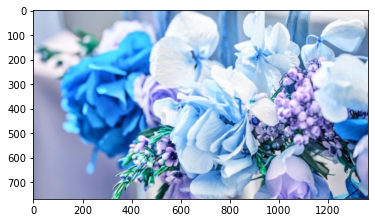

In [18]:
# show the first image
plt.imshow(new_images[0])

In [ ]:
# read the training histogram from GCS
bucket = storage.Client().bucket(GCS_BUCKET)  
blob = bucket.get_blob('train_hist.csv')
loadedHist = blob.download_as_text(encoding = 'utf-8')
loadedHist = np.loadtxt(loadedHist, encoding = 'utf8')
    
# This loadedArr is a 2D array, therefore we need to convert it to the original array shape.
# reshaping to get original matrice with original shape.
loadedHist = loadedHist.reshape(loadedHist.shape[0], loadedHist.shape[1] // loadedHist.shape[0], loadedHist.shape[0]).astype('float32')

channels = [0, 1, 2]
hist_size = [256] * 3
hist_ranges = [0, 256] * 3

# compute the image histograms for served image
image_hist = cv2.calcHist(new_images,
                          channels,
                          None,
                          hist_size,
                          hist_ranges,
                          accumulate = True)
cv2.normalize(image_hist, image_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# compute the comparison
corr = cv2.compareHist(loadedHist, image_hist, 0)
batt = cv2.compareHist(loadedHist, image_hist, 3)

#load the threshold for comparison
blob = bucket.get_blob('train_threshold.txt')
thresholds = [float(blob.download_as_text().split(',')[0]),
              float(blob.download_as_text().split(',')[1])]

if corr <= thresholds[0] and batt >= thresholds[1]:
    print('New data is within threshold for data drift.')
else:
    print(f'Train serve data drift detected. Correlation is {corr} and Battacharyya distance is {batt}, compared with {thresholds[0]} and {thresholds[1]} for training vs test data.')

## Implement a component to automate the checking of incoming image data

This function outputs a yaml file that can be picked up by the pipeline building script as required for compilation

In [ ]:
@component(packages_to_install=["google-cloud-storage","opencv-python-headless","pandas","pyarrow","fsspec","gcsfs"],
           base_image='python:3.9',
           output_component_file="./build/check_image_component.yaml")
def check_image_component(
    project_dict: dict,
    img_to_check # images to be passed as a np.ndarray
    ):
    import cv2
    import urllib
    import numpy as np
    import pandas as pd
    import gcsfs
    import logging
    
    logging.basicConfig(level=logging.INFO)

    PROJECT_ID = project_dict['PROJECT_ID']
    GCS_BUCKET = project_dict['GCS_BUCKET']

    #load the training data histogram
    fs = gcsfs.GCSFileSystem(project=f'{PROJECT_ID}')
    with fs.open(f'gs://{GCS_BUCKET}/train_hist.csv') as f:
        loadedHist = np.loadtxt(f,dtype='float32')

    # This loadedArr is a 2D array, therefore we need to convert it to the original array shape.
    # reshaping to get original matrice with original shape.
    loadedHist = loadedHist.reshape(loadedHist.shape[0], loadedHist.shape[1] // loadedHist.shape[0], loadedHist.shape[0]).astype('float32')

    channels = [0, 1, 2]
    hist_size = [256] * 3
    hist_ranges = [0, 256] * 3

    # compute the image histograms for served image
    image_hist = cv2.calcHist(image_to_check,
                              channels,
                              None,
                              hist_size,
                              hist_ranges,
                              accumulate = True)
    cv2.normalize(image_hist, image_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # compute the comparison
    corr = cv2.compareHist(loadedHist, image_hist, 0)
    batt = cv2.compareHist(loadedHist, image_hist, 3)

    #load the threshold for comparison
    fs = gcsfs.GCSFileSystem(project=f'{PROJECT_ID}')
    with fs.open(f'gs://{GCS_BUCKET}/train_threshold.txt') as f:
        thresholds = np.loadtxt(f,dtype='float32')

    if corr <= thresholds[0] and batt <= thresholds[1]:
        logging.info('New data is within threshold for data drift.')
    else:
        logging.info(f'Train serve data drift detected. Correlation is {corr} and Battacharyya distance is {batt}, compared with {thresholds[0]} and {thresholds[1]} for training vs test data.')